In [1]:
import sys
sys.path.append(r'../')
import mat73
import numpy as np
from tqdm import tqdm
from scipy import signal
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.animation as animation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%reload_ext autoreload
%autoreload 2
from functions import *

In [2]:
from cebra import CEBRA

In [3]:
data = Database()
X = data.neuron_traces.T
B = data.states

## Preprocessing the data

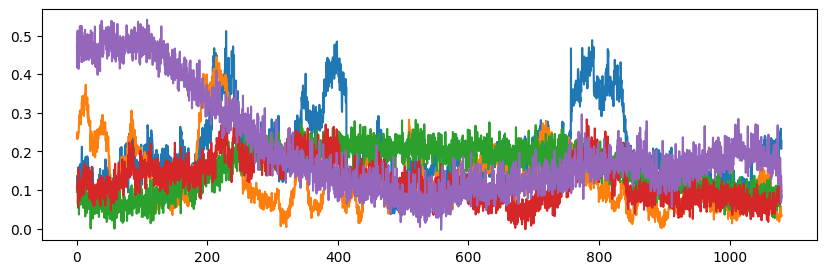

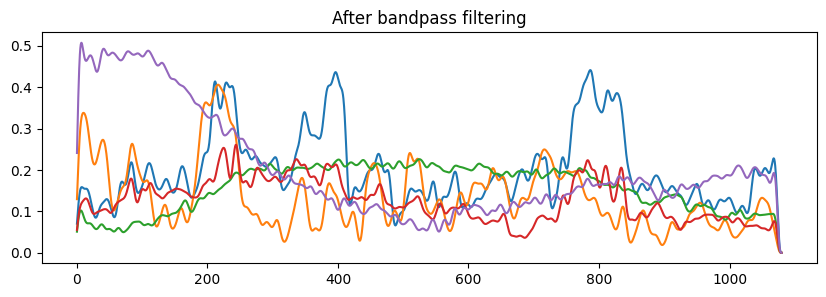

(array([], dtype=int64), array([], dtype=int64))

In [4]:
time = 1/data.fps*np.arange(0,X.shape[0])
filtered = bandpass(X.T, f_l=1e-10, f_h=0.05, sampling_freq=data.fps).T

nn = np.arange(80,85)
plt.figure(figsize = [10,3])
plt.plot(time, X[:,nn])
plt.figure(figsize = [10,3])
plt.plot(time, filtered[:,nn])
plt.title('After bandpass filtering')
plt.show()

X = filtered

X = X - np.min(X) ### cebra doesnt work otherwise if there are negative values
np.where(X<0)

### Preparing the data  

In [4]:
# Preparing the data (Method new)
win = 1
win += 1
gap = 1
X_win = np.zeros((X.shape[0]-win-gap, win, X.shape[1]))

for i, _ in enumerate(X_win):
    X_win[i] = X[i:i+win]

Xwin0, Xwin1 = X_win[:,:-1,:], X_win[:,1:,:]
B_1 = B[1:]
X_paired = np.array([Xwin0, Xwin1])
X_paired = np.transpose(X_paired, axes=(1,0,2,3))

# Train test split 
kf = KFold(n_splits=7)
for i, (train_index, test_index) in enumerate(kf.split(X_win)):
    if i==4: 
        # Train test split based on a fold
        X_train, X_test = X_paired[train_index], X_paired[test_index]
        B_train_1, B_test_1 = B_1[train_index], B_1[test_index]        
        
        # Creating datasets for tf
        batch_size = 100
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, B_train_1))
        train_dataset = train_dataset.batch(batch_size)
        
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, B_test_1))
        test_dataset = test_dataset.batch(batch_size)

## CEBRA behaviour

In [6]:
max_iterations = 5000 #default is 5000.
output_dimension = 32 #here, we set as a variable for hypothesis testing below.

In [7]:
cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_posdir3_model.fit(X_train[:,0,0,:], B_train_1)

pos:  0.0433 neg:  5.4603 total:  5.5036 temperature:  1.0000: 100%|█| 5000/5000 


CEBRA(batch_size=512, conditional='time_delta', max_iterations=5000,
      model_architecture='offset10-model', output_dimension=3, temperature=1,
      time_offsets=10, verbose=True)

#### Projecting into latent space

In [8]:
Y0_tr = cebra_posdir3_model.transform(X_train[:,0,0,:])
Y1_tr = cebra_posdir3_model.transform(X_train[:,1,0,:])
Ydiff_tr = Y1_tr - Y0_tr

Y0_tst = cebra_posdir3_model.transform(X_test[:,0,0,:])
Y1_tst = cebra_posdir3_model.transform(X_test[:,1,0,:])
Ydiff_tst = Y1_tst - Y0_tst

np.savetxt('Saved_Y/Y0_tr__cebra_B.csv',Y0_tr)
np.savetxt('Saved_Y/Y1_tr__cebra_B.csv',Y1_tr)
np.savetxt('Saved_Y/Y0_tst__cebra_B.csv',Y0_tst)
np.savetxt('Saved_Y/Y1_tst__cebra_B.csv',Y1_tst)
np.savetxt('Saved_Y/B_train_1__cebra_B.csv',B_train_1)
np.savetxt('Saved_Y/B_test_1__cebra_B.csv',B_test_1)

In [9]:
algorithm = 'cebra_B'
Y0_tr = np.loadtxt('Saved_Y/Y0_tr__'+ algorithm +'.csv')
Y1_tr = np.loadtxt('Saved_Y/Y1_tr__'+ algorithm +'.csv')
Y0_tst = np.loadtxt('Saved_Y/Y0_tst__'+ algorithm +'.csv')
Y1_tst = np.loadtxt('Saved_Y/Y1_tst__'+ algorithm +'.csv')
B_train_1 = np.loadtxt('Saved_Y/B_train_1__'+ algorithm +'.csv').astype(int)
B_test_1 = np.loadtxt('Saved_Y/B_test_1__'+ algorithm +'.csv').astype(int)


### Plotting latent space dynamics


(0.0, 2686.0, -0.5, 0.5)

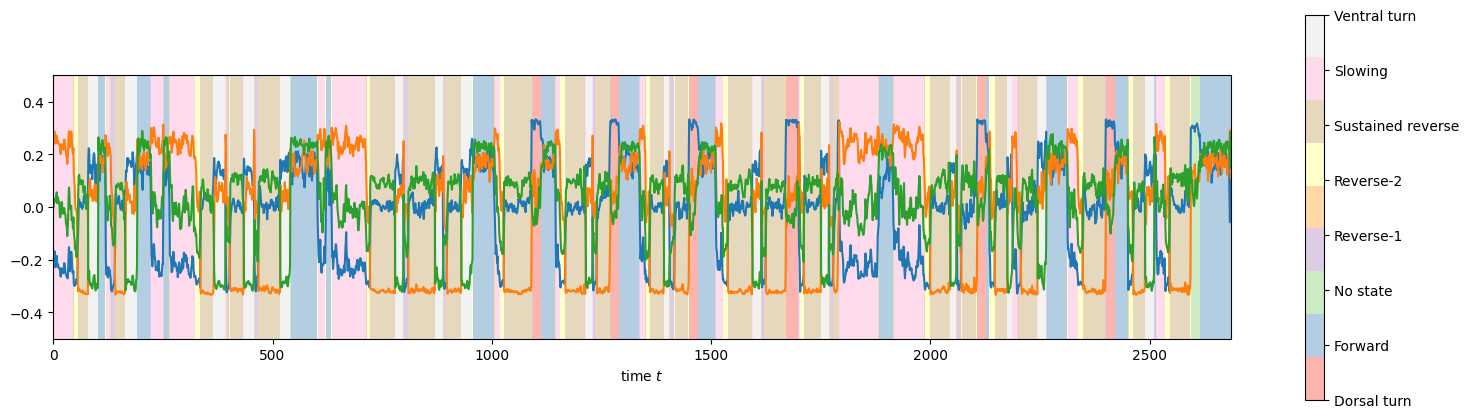

In [10]:
### Dynamics in the (learned) Y space
%matplotlib inline
plt.figure(figsize=(19,5))
plt.imshow([B_train_1],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y0_tr/Y0_tr.max()/3)
plt.xlabel("time $t$")
plt.axis([0,Y0_tr.shape[0],-0.5,0.5])

In [14]:
%matplotlib notebook
plot_phase_space(Y0_tr, B_train_1,show_points=True)

## CEBRA time

In [16]:
cebra_time3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.12,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_time3_model.fit(X_train[:,0,0,:])

pos:  0.0023 neg:  5.4753 total:  5.4777 temperatu


CEBRA(batch_size=512, conditional='time', model_architecture='offset10-model',
      output_dimension=3, temperature=1.12, time_offsets=10, verbose=True)

#### Projecting into latent space

In [17]:
Y0_tr = cebra_time3_model.transform(X_train[:,0,0,:])
Y1_tr = cebra_time3_model.transform(X_train[:,1,0,:])
Ydiff_tr = Y1_tr - Y0_tr

Y0_tst = cebra_time3_model.transform(X_test[:,0,0,:])
Y1_tst = cebra_time3_model.transform(X_test[:,1,0,:])
Ydiff_tst = Y1_tst - Y0_tst

np.savetxt('Saved_Y/Y0_tr__cebra_time.csv',Y0_tr)
np.savetxt('Saved_Y/Y1_tr__cebra_time.csv',Y1_tr)
np.savetxt('Saved_Y/Y0_tst__cebra_time.csv',Y0_tst)
np.savetxt('Saved_Y/Y1_tst__cebra_time.csv',Y1_tst)
np.savetxt('Saved_Y/B_train_1__cebra_time.csv',B_train_1)
np.savetxt('Saved_Y/B_test_1__cebra_time.csv',B_test_1)

In [18]:
'''algorithm = 'cebra_time'
Y0_tr = np.loadtxt('Saved_Y/Y0_tr__'+ algorithm +'.csv')
Y1_tr = np.loadtxt('Saved_Y/Y1_tr__'+ algorithm +'.csv')
Y0_tst = np.loadtxt('Saved_Y/Y0_tst__'+ algorithm +'.csv')
Y1_tst = np.loadtxt('Saved_Y/Y1_tst__'+ algorithm +'.csv')
B_train_1 = np.loadtxt('Saved_Y/B_train_1__'+ algorithm +'.csv').astype(int)
B_test_1 = np.loadtxt('Saved_Y/B_test_1__'+ algorithm +'.csv').astype(int)
'''

"algorithm = 'cebra_time'\nY0_tr = np.loadtxt('Saved_Y/Y0_tr__'+ algorithm +'.csv')\nY1_tr = np.loadtxt('Saved_Y/Y1_tr__'+ algorithm +'.csv')\nY0_tst = np.loadtxt('Saved_Y/Y0_tst__'+ algorithm +'.csv')\nY1_tst = np.loadtxt('Saved_Y/Y1_tst__'+ algorithm +'.csv')\nB_train_1 = np.loadtxt('Saved_Y/B_train_1__'+ algorithm +'.csv').astype(int)\nB_test_1 = np.loadtxt('Saved_Y/B_test_1__'+ algorithm +'.csv').astype(int)\n"

### Plotting latent space dynamics


(0.0, 2686.0, -0.5, 0.5)

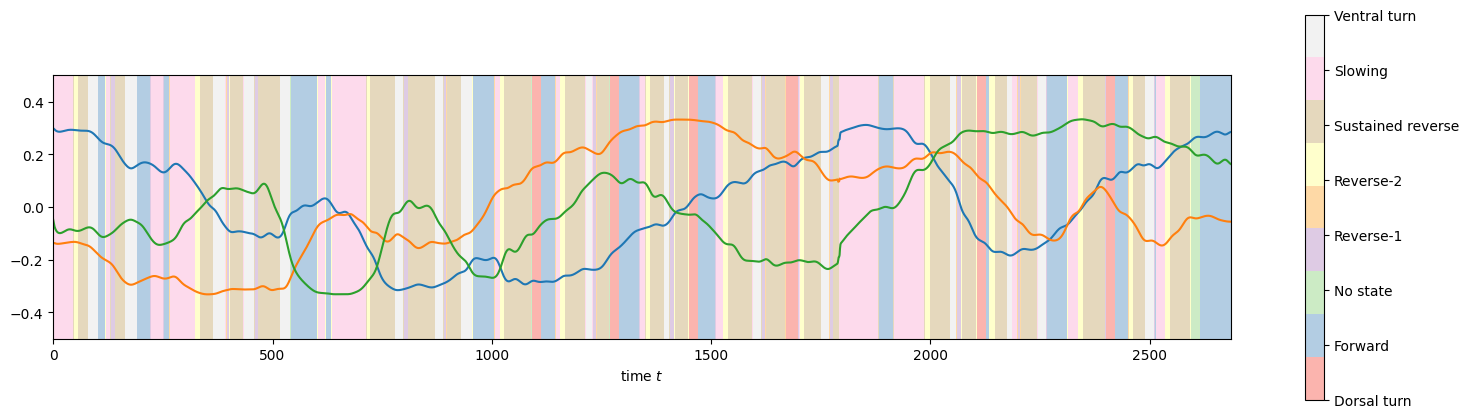

In [19]:
### Dynamics in the (learned) Y space
%matplotlib inline
plt.figure(figsize=(19,5))
plt.imshow([B_train_1],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y0_tr/Y0_tr.max()/3)
plt.xlabel("time $t$")
plt.axis([0,Y0_tr.shape[0],-0.5,0.5])

<IPython.core.display.Javascript object>


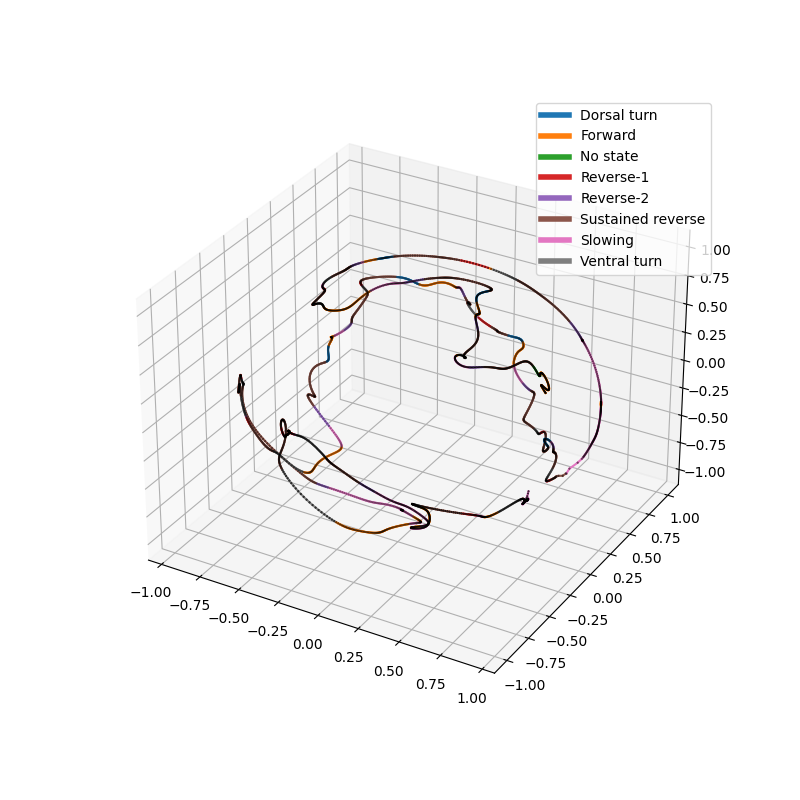

<Axes3D: >

In [21]:
%matplotlib notebook
plot_phase_space(Y1_tr, B_train_1,show_points=True)

## CEBRA hybrid

In [22]:
cebra_hybrid_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid = True)

cebra_hybrid_model.fit(X_train[:,0,0,:], B_train_1.astype(float))

behavior_pos:  0.4873 behavior_neg:  5.4135 behavi


CEBRA(batch_size=512, conditional='time_delta', hybrid=True,
      model_architecture='offset10-model', output_dimension=3, temperature=1,
      time_offsets=10, verbose=True)

#### Projecting into latent space

In [23]:
Y0_tr = cebra_hybrid_model.transform(X_train[:,0,0,:])
Y1_tr = cebra_hybrid_model.transform(X_train[:,1,0,:])
Ydiff_tr = Y1_tr - Y0_tr

Y0_tst = cebra_hybrid_model.transform(X_test[:,0,0,:])
Y1_tst = cebra_hybrid_model.transform(X_test[:,1,0,:])
Ydiff_tst = Y1_tst - Y0_tst

np.savetxt('Saved_Y/Y0_tr__cebra_hybrid.csv',Y0_tr)
np.savetxt('Saved_Y/Y1_tr__cebra_hybrid.csv',Y1_tr)
np.savetxt('Saved_Y/Y0_tst__cebra_hybrid.csv',Y0_tst)
np.savetxt('Saved_Y/Y1_tst__cebra_hybrid.csv',Y1_tst)
np.savetxt('Saved_Y/B_train_1__cebra_hybrid.csv',B_train_1)
np.savetxt('Saved_Y/B_test_1__cebra_hybrid.csv',B_test_1)

In [24]:
algorithm = 'cebra_hybrid'
Y0_tr = np.loadtxt('Saved_Y/Y0_tr__'+ algorithm +'.csv')
Y1_tr = np.loadtxt('Saved_Y/Y1_tr__'+ algorithm +'.csv')
Y0_tst = np.loadtxt('Saved_Y/Y0_tst__'+ algorithm +'.csv')
Y1_tst = np.loadtxt('Saved_Y/Y1_tst__'+ algorithm +'.csv')
B_train_1 = np.loadtxt('Saved_Y/B_train_1__'+ algorithm +'.csv').astype(int)
B_test_1 = np.loadtxt('Saved_Y/B_test_1__'+ algorithm +'.csv').astype(int)


### Plotting latent space dynamics


(0.0, 2686.0, -0.5, 0.5)

<IPython.core.display.Javascript object>


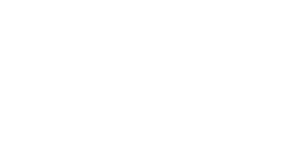

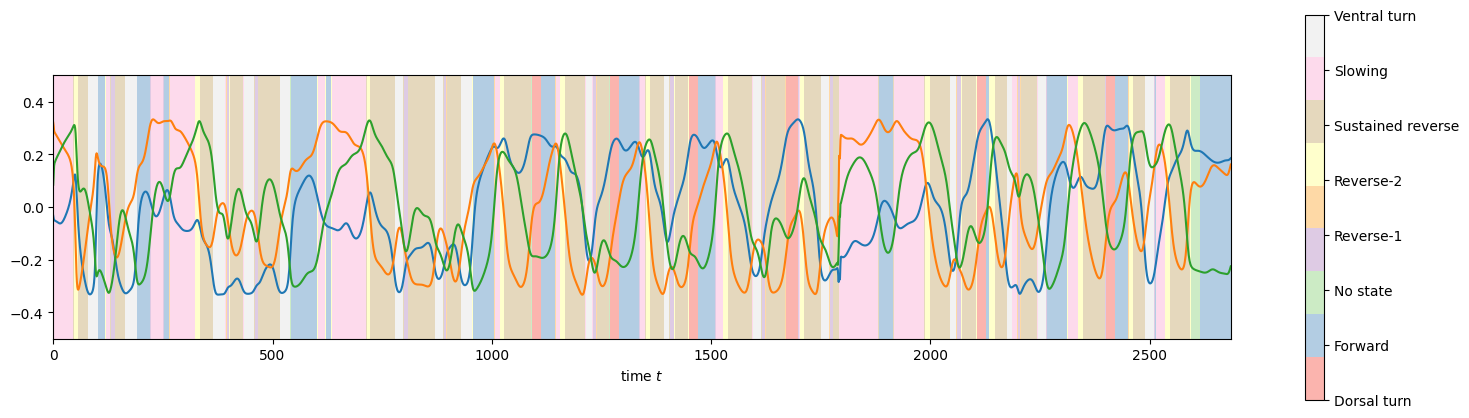

In [25]:
### Dynamics in the (learned) Y space
%matplotlib inline
plt.figure(figsize=(19,5))
plt.imshow([B_train_1],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y0_tr/Y0_tr.max()/3)
plt.xlabel("time $t$")
plt.axis([0,Y0_tr.shape[0],-0.5,0.5])

<IPython.core.display.Javascript object>


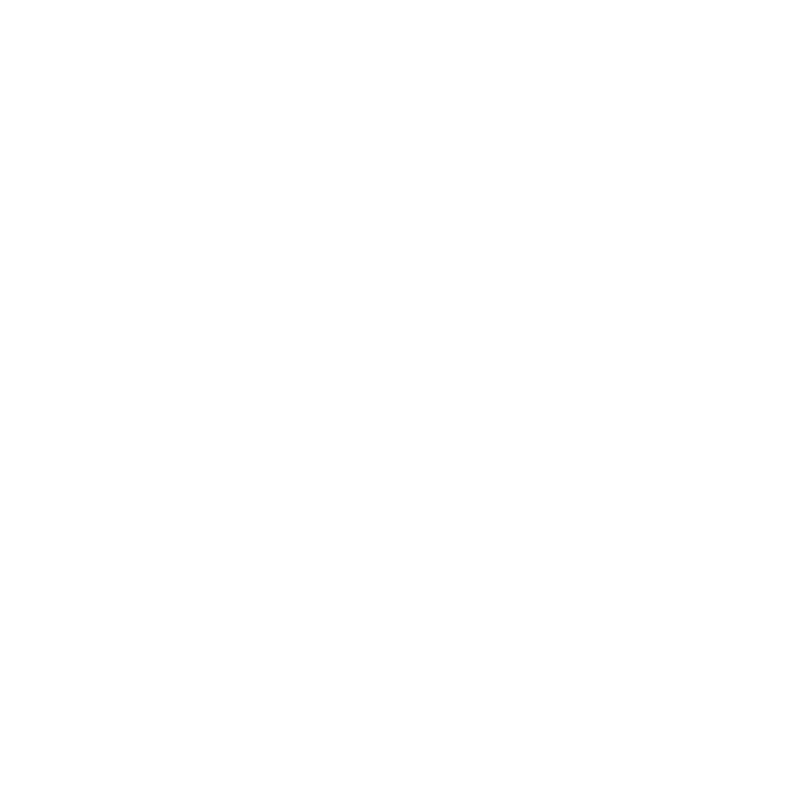

<Axes3D: >

In [26]:
%matplotlib notebook
plot_phase_space(Y0_tr, B_train_1,show_points=True)